In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import os
import os.path as osp
import sys
import time
import glob
import cv2
from tqdm import tqdm, tnrange, tqdm_notebook
from collections import OrderedDict
import PIL
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch import Tensor
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

import torchvision
from torchvision import transforms, datasets, models

from mpl_toolkits.axes_grid1 import ImageGrid

from dataset import COCODataset
import utils
from utils import load_image, postprocessing

# Download COCO dataset

Run "get_coco_dataset.sh" to download the training data if you haven't already

In [2]:
#Uncomment to run bash script
#!./data/get_coco_dataset.sh

In [3]:
def load_coco(path):
    with open(path) as f:
        return [line.rstrip("\n") for line in f.readlines()]

In [4]:
coco_path = './coco.names'
classes = load_coco(coco_path)

# Paths

In [5]:
CUDA = True
use_cuda = True
weight_path = './yolov3.weights'
backbone_weight_path = './darknet53.conv.74'
coco_path = './data/coco.names'
train_target_txt = "./data/coco/trainvalno5k.txt"
valid_target_txt = "./data/coco/5k.txt"

# Draw

In [6]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=0.5))
    draw_outline(patch, 2)
    
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def bbox_x1y1x2y2_to_xywh(box):
    bx, by = box[..., 0], box[..., 1]
    bw = box[..., 2] - box[..., 0]
    bh = box[..., 3] - box[..., 1]
    box[..., 0], box[..., 1], box[..., 2], box[..., 3] = bx, by, bw, bh
    return box

def bbox_x1y1x2y2_to_cxcywh(box):
    bw = box[..., 2] - box[..., 0]
    bh = box[..., 3] - box[..., 1]
    cx, cy = box[..., 0] + bw / 2, box[..., 1] + bh / 2
    box[..., 0], box[..., 1], box[..., 2], box[..., 3] = cx, cy, bw, bh
    return box

def bbox_cxcywh_to_x1y1x2y2(box):
    x1, x2 = box[..., 0] - box[..., 2] / 2, box[..., 0] + box[..., 2] / 2
    y1, y2 = box[..., 1] - box[..., 3] / 2, box[..., 1] + box[..., 3] / 2
    box[..., 0], box[..., 1], box[..., 2], box[..., 3] = x1, y1, x2, y2
    return box

def show_output(img, dets):
    ax = show_img(img, figsize=(16,8))
    for d in dets:
        rect = bbox_x1y1x2y2_to_xywh(d)
        draw_rect(ax, rect[:4])
        c = classes[d[-1].int().item()]
        draw_text(ax, rect[:2], c)

In [7]:
import matplotlib.ticker as plticker
def show_grid(ax, grid_interval):
    loc = plticker.MultipleLocator(base=grid_interval)
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)
    ax.grid(which='major', axis='both', linestyle='-')
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
    return ax


# Dataset

# Build target tensor to train against

## Multi box IOU calcuation

In [8]:
# mode - x1y1x2y2, cxcywh
def bbox_iou(b1, b2, mode="x1y1x2y2"):
    #num_box = bbox.shape[0]
    
    if mode == "x1y1x2y2":
        b1_x1, b1_y1, b1_x2, b1_y2 = b1[...,0], b1[...,1], b1[...,2], b1[...,3]
        b2_x1, b2_y1, b2_x2, b2_y2 = b2[...,0], b2[...,1], b2[...,2], b2[...,3]  
    elif mode == "cxcywh":
        b1_x1, b1_x2 = b1[..., 0] - b1[..., 2] / 2, b1[..., 0] + b1[..., 2] / 2
        b1_y1, b1_y2 = b1[..., 1] - b1[..., 3] / 2, b1[..., 1] + b1[..., 3] / 2
        b2_x1, b2_x2 = b2[..., 0] - b2[..., 2] / 2, b2[..., 0] + b2[..., 2] / 2
        b2_y1, b2_y2 = b2[..., 1] - b2[..., 3] / 2, b2[..., 1] + b2[..., 3] / 2
    
    num_b1 = b1.shape[0]
    num_b2 = b2.shape[0]
    
    inter_x1 = torch.max(b1_x1.unsqueeze(1).repeat(1, num_b2), b2_x1)
    inter_y1 = torch.max(b1_y1.unsqueeze(1).repeat(1, num_b2), b2_y1)
    inter_x2 = torch.min(b1_x2.unsqueeze(1).repeat(1, num_b2), b2_x2)
    inter_y2 = torch.min(b1_y2.unsqueeze(1).repeat(1, num_b2), b2_y2)
            
    inter_area = torch.clamp(inter_x2 - inter_x1, min=0) * torch.clamp(inter_y2 - inter_y1, min=0)
    b1_area = (b1_x2 - b1_x1) * (b1_y2 - b1_y1)
    b2_area = (b2_x2 - b2_x1) * (b2_y2 - b2_y1)
    union_area = b1_area.unsqueeze(1).repeat(1, num_b2) + b2_area.unsqueeze(0).repeat(num_b1, 1) - inter_area
    
    iou = inter_area / union_area
    return iou

## Yolo Loss layer

In [19]:
class YoloLoss(nn.Module):
    def __init__(self, anchors, img_dim, numClass):
        super().__init__()
        self.anchors = anchors
        self.img_dim = img_dim
                
        self.numClass = numClass
        self.bbox_attrib = 5 + numClass
        
        
        self.lambda_xy = 2.5
        self.lambda_wh = 2.5
        self.lambda_conf = 2 #1.0
        self.lambda_cls = 2 #1.0
        
        self.obj_scale = 1 #5
        self.noobj_scale = 0.5
        
        self.ignore_thres = 0.5
        
        self.mseloss = nn.MSELoss()
        self.bceloss = nn.BCELoss()
        
        self.training = False

        
    def forward(self, x, target=None):
        #x : bs x nA*(5 + num_classes) * h * w
        nB = x.shape[0]
        nA = len(self.anchors)
        nH, nW = x.shape[2], x.shape[3]
        stride = self.img_dim[0] / nH
        anchors = torch.FloatTensor(self.anchors) / stride
        
        #Reshape predictions from [B x [A * (5 + numClass)] x H x W] to [B x A x H x W x (5 + numClass)]
        preds = x.view(nB, nA, self.bbox_attrib, nH, nW).permute(0, 1, 3, 4, 2).contiguous()
        
        # tx, ty, tw, wh
        preds_xy = preds[..., :2].sigmoid()
        preds_wh = preds[..., 2:4]
        preds_conf = preds[..., 4].sigmoid()
        preds_cls = preds[..., 5:].sigmoid()
        
        # Calculate cx, cy, anchor mesh
        mesh_x = torch.arange(nW).repeat(nW,1).unsqueeze(2)
        mesh_y = torch.arange(nH).repeat(nH,1).t().unsqueeze(2)
        mesh_xy = torch.cat((mesh_x,mesh_y), 2)
        mesh_anchors = anchors.view(1, nA, 1, 1, 2).repeat(1, 1, nH, nW, 1)
        
        # pred_boxes holds bx,by,bw,bh
        pred_boxes = torch.FloatTensor(preds[..., :4].shape)
        pred_boxes[..., :2] = preds_xy.cpu().detach() + mesh_xy # sig(tx) + cx
        pred_boxes[..., 2:4] = preds_wh.cpu().detach().exp() * mesh_anchors  # exp(tw) * anchor
        
        if target is not None:
            obj_mask, noobj_mask, tconf, tcls, tx, ty, tw, th, nCorrect, nGT = self.build_target_tensor(
                                                                    pred_boxes, target.cpu(), anchors, (nH, nW), self.numClass,
                                                                    self.ignore_thres)
            
            recall = float(nCorrect / nGT) if nGT else 1
            
            # masks for loss calculations
            obj_mask, noobj_mask = obj_mask.cuda(), noobj_mask.cuda()
            cls_mask = (obj_mask == 1)
            tconf, tcls = tconf.cuda(), tcls.cuda()
            tx, ty, tw, th = tx.cuda(), ty.cuda(), tw.cuda(), th.cuda()

            loss_x = self.lambda_xy * self.bceloss(preds_xy[..., 0] * obj_mask, tx * obj_mask)
            loss_y = self.lambda_xy * self.bceloss(preds_xy[..., 1] * obj_mask, ty * obj_mask)
            loss_w = self.lambda_wh * self.mseloss(preds_wh[..., 0] * obj_mask, tw * obj_mask) / 2
            loss_h = self.lambda_wh * self.mseloss(preds_wh[..., 1] * obj_mask, th * obj_mask) / 2
            loss_conf = self.lambda_conf * \
                        ( self.obj_scale * self.bceloss(preds_conf * obj_mask, obj_mask) + \
                          self.noobj_scale * self.bceloss(preds_conf * noobj_mask, noobj_mask * 0) )
            loss_cls = self.lambda_cls * self.bceloss(preds_cls[cls_mask], tcls[cls_mask])
            loss =  loss_x + loss_y + loss_w + loss_h + loss_conf + loss_cls
                
            return loss, loss.item(), loss_x.item(), loss_y.item(), loss_w.item(), loss_h.item(), \
                   loss_conf.item(), loss_cls.item(), \
                   nCorrect, nGT
#           return obj_mask, noobj_mask
           
        # Return predictions if not training 
        out = torch.cat((pred_boxes.cuda() * stride, 
                         preds_conf.cuda().unsqueeze(4),
                         preds_cls.cuda() ), 4)
        
        # Reshape predictions from [B x A x H x W x (5 + numClass)] to [B x [A x H x W] x (5 + numClass)]
        # such that predictions at different stride could concatenated on same dimension
        out = out.permute(0, 2, 3, 1, 4).contiguous().view(nB, nA*nH*nW, self.bbox_attrib)
        return out
        
        
        
        return obj_mask, noobj_mask
        

    def build_target_tensor(self, preds, target, anchors, inp_dim, numClass, ignore_thres):
        nB = target.shape[0]
        nA = len(anchors)
        nH, nW = inp_dim[0], inp_dim[1]
        nCorrect = 0
        nGT = 0
        target = target.float()

        obj_mask = torch.zeros(nB, nA, nH, nW, requires_grad=False)
        noobj_mask = torch.ones(nB, nA, nH, nW, requires_grad=False)
        tconf= torch.zeros(nB, nA, nH, nW, requires_grad=False)
        tcls= torch.zeros(nB, nA, nH, nW, numClass, requires_grad=False)
        tx = torch.zeros(nB, nA, nH, nW, requires_grad=False)
        ty = torch.zeros(nB, nA, nH, nW, requires_grad=False)
        tw = torch.zeros(nB, nA, nH, nW, requires_grad=False)
        th = torch.zeros(nB, nA, nH, nW, requires_grad=False)

        for b in range(nB):
            for t in range(target.shape[1]):
                if target[b, t].sum() == 0:
                    break;
                nGT += 1

                gx = target[b, t, 1] * nW
                gy = target[b, t, 2] * nH
                gw = target[b, t, 3] * nW
                gh = target[b, t, 4] * nH
                gi = int(gx)
                gj = int(gy)

                #preds - [bs x A x W x H x (5+C)]  
                tmp_gt_boxes = torch.FloatTensor([gx, gy, gw, gh])
                tmp_pred_boxes = preds[b].view(-1, 4)
                tmp_ious, _ = torch.max(bbox_iou(tmp_pred_boxes, tmp_gt_boxes, mode="cxcywh"), 1)
                ignore_idx = (tmp_ious > ignore_thres).view(nA, nH, nW)
                noobj_mask[b][ignore_idx] = 0
                
                #find best fit anchor for each ground truth box
                tmp_gt_boxes = torch.FloatTensor([[0, 0, gw, gh]])
                tmp_anchor_boxes = torch.cat((torch.zeros(nA, 2), anchors), 1)
                tmp_ious = bbox_iou(tmp_anchor_boxes, tmp_gt_boxes, mode="cxcywh")
                best_anchor = torch.argmax(tmp_ious, 0).item()
                
                #find iou for best fit anchor prediction box against the ground truth box
                tmp_gt_box = torch.FloatTensor([gx, gy, gw, gh]).unsqueeze(0)
                tmp_pred_box = preds[b, best_anchor, gj, gi].view(-1, 4)
                tmp_iou = bbox_iou(tmp_gt_box, tmp_pred_box, mode="cxcywh")
                
                if tmp_iou > 0.5:
                    nCorrect += 1

                obj_mask[b, best_anchor, gj, gi] = 1
                tconf[b, best_anchor, gj, gi] = 1
                tcls[b, best_anchor, gj, gi, int(target[b, t, 0])] = 1
                tx[b, best_anchor, gj, gi] = gx - gi
                ty[b, best_anchor, gj, gi] = gy - gj
                tw[b, best_anchor, gj, gi] = torch.log(gw / anchors[best_anchor, 0] + 1e-16)
                th[b, best_anchor, gj, gi] = torch.log(gh / anchors[best_anchor, 1] + 1e-16)

        return obj_mask, noobj_mask, tconf, tcls, tx, ty, tw, th, nCorrect, nGT

## Modify YoloNet (from yolo_detect.ipynb)

In [10]:
import darknet
from darknet import Darknet, PreDetectionConvGroup, UpsampleGroup, WeightManager

class YoloNet(nn.Module):
    def __init__(self, img_dim, anchors = [10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326]):
        super().__init__()
        nin = 32
        self.numClass = 80
        self.img_dim = img_dim
        self.stat_keys = ['loss', 'loss_x', 'loss_y', 'loss_w', 'loss_h', 'loss_conf', 'loss_cls',
                          'nCorrect', 'nGT', 'recall']
        
        anchors = [(anchors[i], anchors[i+1]) for i in range(0,len(anchors),2)]
        anchors = [anchors[i:i+3] for i in range(0, len(anchors), 3)][::-1]
                
        self.feature = Darknet([1,2,8,8,4])
        self.feature.addCachedOut(61)
        self.feature.addCachedOut(36)
        
        self.pre_det1 = PreDetectionConvGroup(1024, 512)
        self.yolo1 = YoloLoss(anchors[0], img_dim, self.numClass)
        self.pre_det1.addCachedOut(-3) #Fetch output from 4th layer backward including yolo layer
        
        self.up1 = UpsampleGroup(512)
        self.pre_det2 = PreDetectionConvGroup(768, 256)
        self.yolo2 = YoloLoss(anchors[1], img_dim, self.numClass)
        self.pre_det2.addCachedOut(-3)
        
        self.up2 = UpsampleGroup(256)
        self.pre_det3 = PreDetectionConvGroup(384, 128)
        self.yolo3 = YoloLoss(anchors[2], img_dim, self.numClass)
        
        
        
    def forward(self, x, target=None):
        #Extract features
        out = self.feature(x)
                
        #Detection layer 1
        out = self.pre_det1(out)
        det1 = self.yolo1(out, target)
        
        #Upsample 1
        r_head1 = self.pre_det1.getCachedOut(-3)
        r_tail1 = self.feature.getCachedOut(61)
        out = self.up1(r_head1,r_tail1)
                
        #Detection layer 2
        out = self.pre_det2(out)
        det2 = self.yolo2(out, target)
        
        #Upsample 2
        r_head2 = self.pre_det2.getCachedOut(-3)
        r_tail2 = self.feature.getCachedOut(36)
        out = self.up2(r_head2,r_tail2)
                
        #Detection layer 3
        out = self.pre_det3(out)
        det3 = self.yolo3(out, target)
        
        if target is not None:
            loss, *out = [sum(det) for det in zip(det1, det2, det3)]
            self.stats = dict(zip(self.stat_keys, out))
            self.stats['recall'] = self.stats['nCorrect'] / self.stats['nGT'] if self.stats['nGT'] else 1
            return loss
        else:
            predictions = postprocessing(torch.cat((det1,det2,det3), 1), self.numClass, obj_conf_thr=0.5)
            return predictions
    
    # Format : pytorch / darknet
    def saveWeight(self, weights_path, format='pytorch'):
        if format == 'pytorch':
            torch.save(self.state_dict(), weights_path)
        elif format == 'darknet':
            raise NotImplementedError
    
    def loadWeight(self, weights_path, format='pytorch'):
        if format == 'pytorch':
            weights = torch.load(weights_path, map_location=lambda storage, loc: storage)
            self.load_state_dict(weights)
        elif format == 'darknet':
            wm = WeightManager(self)
            wm.loadWeight(weights_path)

# Test forward pass and backpropagation

In [20]:
def test_forward_pass(img_id):
    sz = 416
    bs = 3
    dim = (sz, sz)
    
    net = YoloNet(dim).cuda().eval()
    net.loadWeight(weight_path, format='darknet')

    train_ds = COCODataset(train_target_txt, dim=dim)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=False, num_workers=4)
    
    for batch, (img, labels) in enumerate(train_dl):
        predictions = net(img.cuda(), None)
        for i in range(bs):  
            img_idx = (predictions[:,0] == i).nonzero()
            show_output(img.permute(0, 2, 3, 1)[i], predictions[img_idx,[1,2,3,4,7]])
        #Run only one batch
        break

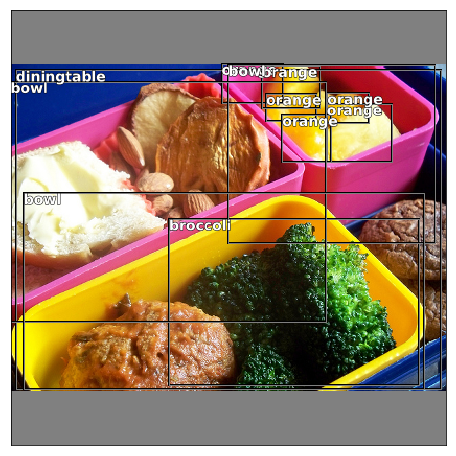

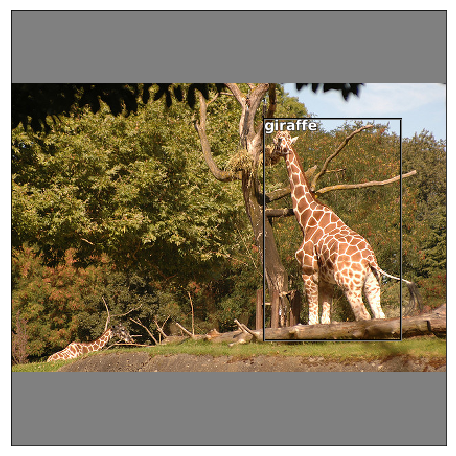

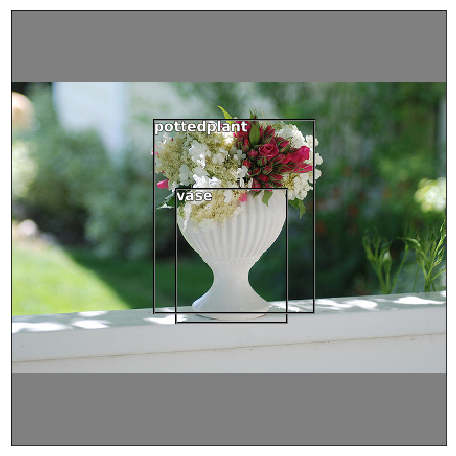

In [21]:
test_forward_pass(23436)

In [18]:
def test_train(img_id):
    sz = 416
    bs = 3
    dim = (sz, sz)
    
    net = YoloNet(dim).cuda().eval()
    net.loadWeight(weight_path, format='darknet')
    
    train_ds = COCODataset(train_target_txt, dim=dim)
    
    img, label = train_ds[img_id]
    img = img.unsqueeze(0).cuda()
    label = label.unsqueeze(0)
    loss = net(img, label)
    loss.backward()
    print(net.stats)
    print(loss.item())

                 
    return loss


In [19]:
test_train(23436)

{'loss': 0.639583658427, 'loss_x': 0.025351718300953507, 'loss_y': 0.020229936868418008, 'loss_w': 0.023300100525375456, 'loss_h': 0.010378140432294458, 'loss_conf': 0.4936102218925953, 'loss_cls': 0.0667135554831475, 'nCorrect': 9, 'nGT': 15, 'recall': 0.6}
0.6395836472511292


tensor(0.6396, device='cuda:0')

# Training

## Set up dataloader

In [11]:
def getData(sz, bs):
    dim = (sz, sz)

    train_ds = COCODataset(train_target_txt, dim=dim)
    valid_ds = COCODataset(valid_target_txt, dim=dim)

    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4)
    valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=True, num_workers=4)
    
    dataloader = dict()
    dataloader['train'] = train_dl
    dataloader['valid'] = valid_dl
    
    return dataloader
    
    

## First time training

In [12]:
def train(dataloader, net, num_epoch,
          lr, backbone_lr,
          wd=0, momentum=0, lr_step_decay=0, lr_step_gamma=0,
          model_id='test', start_epoch=0, weight_dir=None, checkpoint_interval=1,
          use_gpu=True):
    
    feature_params = map(id, net.feature.parameters())
    detection_params = filter(lambda p : id(p) not in feature_params, net.parameters())
    params = [
                {"params": detection_params, "lr": lr},
                {"params": net.feature.parameters(), "lr": backbone_lr}
            ]
    
    optimizer = torch.optim.SGD(params, lr, weight_decay=wd, momentum=momentum)
    scheduler = lr_scheduler.StepLR(optimizer, lr_step_decay, lr_step_gamma)
        
    acc_stats = dict.fromkeys(net.stat_keys + ['acc_datasize'], 0)
    
    for epoch in range(start_epoch, num_epoch):
        for phase in ['train']: #for phase in ['train', 'valid']:
            if phase == 'train':
                net.train(True)
            else:
                net.train(False)
            for batch, (inp, labels) in enumerate(dataloader[phase]):
                if use_gpu:
                    inp, labels = inp.cuda(), labels.cuda()
                
                optimizer.zero_grad()
                
                loss = net(inp, labels)
                loss.backward()
                
                optimizer.step()
                
                datasize = inp.shape[0]
                acc_stats = {k:acc_stats.get(k,0) + net.stats.get(k, 0) for k in set(acc_stats)}
                acc_stats['acc_datasize'] += datasize
                
#                 print('[Epoch:%d[%d/%d], Batch %d/%d] [Losses: x %f, y %f, w %f, h %f, conf %f, cls %f, total %f, recall: %.5f]' %
#                     (epoch, epoch+1, num_epoch, batch, len(dataloader[phase]),
#                     acc_stats['loss_x']/acc_stats['acc_datasize'], acc_stats['loss_y']/acc_stats['acc_datasize'],
#                     acc_stats['loss_w']/acc_stats['acc_datasize'], acc_stats['loss_h']/acc_stats['acc_datasize'],
#                     acc_stats['loss_conf']/acc_stats['acc_datasize'], acc_stats['loss_cls']/acc_stats['acc_datasize'],
#                     acc_stats['loss']/acc_stats['acc_datasize'], acc_stats['nCorrect']/acc_stats['nGT']))
                
                print('[Epoch:%d[%d/%d], Batch %d/%d] [Losses: x %f, y %f, w %f, h %f, conf %f, cls %f, total %f, recall: %.5f]' %
                    (epoch, epoch+1, num_epoch, batch, len(dataloader[phase]),
                    net.stats['loss_x'], net.stats['loss_y'], net.stats['loss_w'],
                    net.stats['loss_h'], net.stats['loss_conf'], net.stats['loss_cls'],
                    loss.item(), net.stats['recall']))
#                 if batch > 20:
#                     break;
            scheduler.step()
        
            if phase == 'train' and ((epoch+1) % checkpoint_interval == 0):
                file_name = 'yolov3_%s_checkpoint_%.4d%s' % (model_id, epoch, '.pth')
                weight_path = osp.join(weight_dir, file_name)
                net.saveWeight(weight_path, format='pytorch')
        

In [14]:
lr = 0.001
momentum=0.9
wd=0.0005
sz = 416
bs = 16
lr_scheduler_decay_step = 20
lr_scheduler_decay_gamma = 0.1
darknet53_lr = 0.001
yolo_lr = 0.01

In [ ]:
epoch = 1
model_id = 'retry'
weight_dir_path = './weights'

net = YoloNet((sz, sz)).cuda()
# Load pretrained pytorch weight
#net.loadWeight(pt_weight_path)
# Load backbone darknet53 weight
net.feature.loadWeight(backbone_weight_path)
# Load full yolo v3 weight
#net.loadWeight(weight_path, 'darknet')


train(getData(sz, bs), net, epoch,
      lr, darknet53_lr,
      wd, momentum, lr_scheduler_decay_step, lr_scheduler_decay_gamma,
      model_id=model_id, start_epoch=0, weight_dir=weight_dir_path, checkpoint_interval=1,
      use_gpu=True)

## Find latest checkpoint saved

In [13]:
def get_latest_checkpoint(model_id, weight_dir_path):
    files_list = [f for f in glob.glob(osp.join(weight_dir_path, '*.pth'))]
    if files_list is None:
        return None, 0
    
    latest_epoch = -1
    latest_i = -1
    for i, f in enumerate(files_list):
        _, f_id, _, epoch = osp.splitext(f)[0].split('_')
        epoch = int(epoch)
        if f_id == model_id and (epoch >= latest_epoch):
            latest_epoch = epoch
            latest_i = i
            
    if latest_i < 0:
        return None, 0
    else:
        return files_list[latest_i], latest_epoch
        

## Test intermediate models

In [17]:
def test_intermediate_model(model_id):
    sz = 416
    bs = 3
    dim = (sz, sz)
    weight_dir_path = './weights'
    pt_weight_path, latest_epoch = get_latest_checkpoint(model_id, weight_dir_path)
    #pt_weight_path = './weights/yolov3_trial_checkpoint_0007.pth'
    print('Loading %s' % pt_weight_path)
    
    net = YoloNet(dim).cuda().eval()
    net.loadWeight(pt_weight_path, format='pytorch')

    train_ds = COCODataset(train_target_txt, dim=dim)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=False, num_workers=4)
    
    for batch, (img, labels) in enumerate(train_dl):
        predictions = net(img.cuda(), None)
        for i in range(bs):
            if predictions.shape[0] != 0:
                img_idx = (predictions[:,0] == i).nonzero()
                show_output(img.permute(0, 2, 3, 1)[i], predictions[img_idx,[1,2,3,4,7]])
            else:
                show_output(img.permute(0, 2, 3, 1)[i], predictions)
        #Run only one batch
        break

Loading ./weights/yolov3_trial_checkpoint_0012.pth


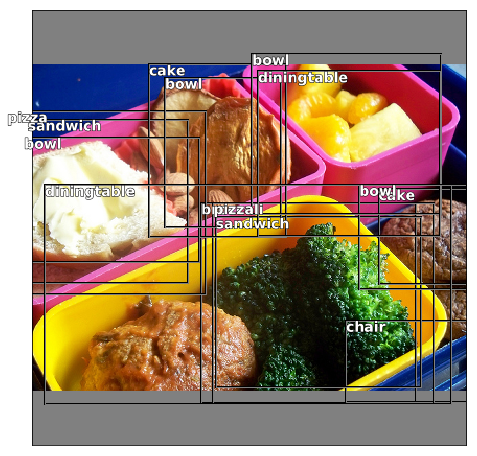

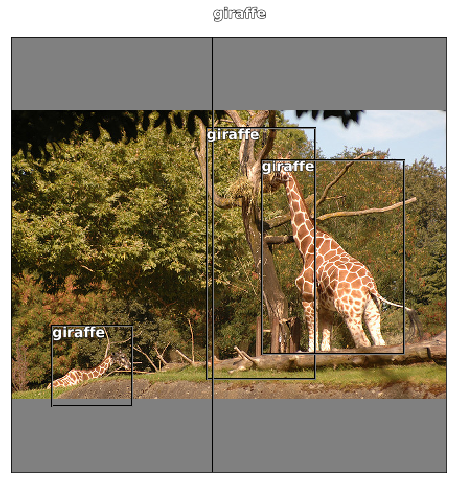

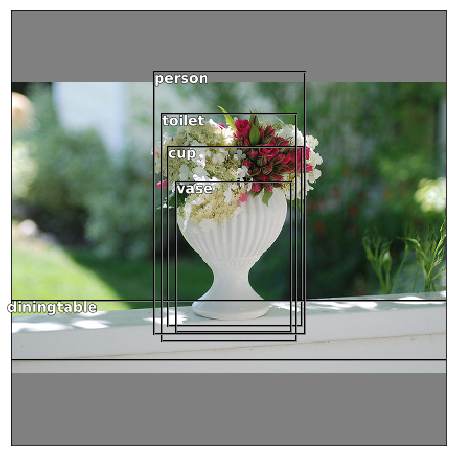

In [18]:
test_intermediate_model('trial')

## Resume training (make sure 'model_id' matches)

In [14]:
lr = 0.001
momentum=0.9
wd=0.0005
sz = 416
bs = 16
lr_scheduler_decay_step = 20
lr_scheduler_decay_gamma = 0.1
darknet53_lr = 0.001
yolo_lr = 0.01

In [15]:
def resume_training(max_epoch, model_id, weight_dir):
    pt_weight_path, latest_epoch = get_latest_checkpoint(model_id, weight_dir)
    if pt_weight_path is not None:
        print('Loading %s' % pt_weight_path)
        
        net = YoloNet((sz, sz)).cuda()
        net.loadWeight(pt_weight_path)
        train(getData(sz, bs), net, max_epoch,
              lr, darknet53_lr,
              wd, momentum, lr_scheduler_decay_step, lr_scheduler_decay_gamma,
              model_id=model_id, start_epoch=latest_epoch+1, weight_dir=weight_dir, checkpoint_interval=1,
              use_gpu=True)
    else:
        print("No checkpoint for %d found" % model_id)

In [ ]:
#epoch 12 changed loss function
epoch = 13
model_id = 'trial'
weight_dir_path = './weights'
resume_training(epoch, model_id, weight_dir_path)